# NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [20]:
import csv                        
from sklearn.svm import LinearSVC
!pip install nltk
import nltk
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [21]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [22]:
def parse_data_line(data_line):
# Should return a tuple of the label as just positive or negative and the statement
# e.g. (label, statement)
    label=data_line[1] #Store the label accross each statement in label array
    statement=data_line[2] #Store the statement in staement array
    return (label, statement) #Return label and statement

In [23]:
import re
# Input: a string of one statement
# A global dictionary of features
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    tokens = re.split(r"\s+",text)
    # normalisation - only by lower casing
    tokens = [t.lower() for t in tokens]
    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [24]:
global_feature_dict = {}
def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    feature_vector = {}
    for token in tokens:
        # Update the global feature dictionary
        global_feature_dict[token] = 0
        # Use binary feature values (1 if the feature is present, 0 otherwise)1
        feature_vector[token] = 1     
    return feature_vector


In [25]:
# TRAINING AND VALIDATING OUR CLASSIFIER
def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(dual = 'auto'))])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [26]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def cross_validate(dataset, folds):
    
    results = []
    fold_size = int(len(dataset) / folds)
    
    # Split the data into features and labels
    features = [data[0] for data in dataset]
    labels = [data[1] for data in dataset]

    # Use KFold to split the data into training and test sets for each fold
    kf = KFold(n_splits=folds, shuffle=True, random_state=50)

    for train_index, test_index in kf.split(features):
        # Split the data into training and test sets for this fold
        train_data, test_data = [features[i] for i in train_index], [features[i] for i in test_index]
        train_true, test_true = [labels[i] for i in train_index], [labels[i] for i in test_index]
        
        # Train the classifier on the training data
        classifier = train_classifier(list(zip(train_data, train_true)))

        # Predict labels on the test data
        predicted_labels = predict_labels(test_data, classifier)

        # Calculate evaluation metrics for this fold
        precision, recall, f1_score, _ = precision_recall_fscore_support(test_true, predicted_labels, average='weighted')
        accuracy = accuracy_score(test_true, predicted_labels)

        # Store the results for this fold
        results.append({
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'accuracy': accuracy
        })

        print("Fold start on items %d - %d - %d - %d" % (train_index[0],train_index[-1],test_index[0], test_index[-1]))
        print("Precision: %.4f, Recall: %.4f, F1 Score: %.4f, Accuracy: %.4f" % (precision, recall, f1_score, accuracy))

    # Calculate average scores across all folds
    cv_results = {
        'precision': sum(result['precision'] for result in results) / len(results),
        'recall': sum(result['recall'] for result in results) / len(results),
        'f1_score': sum(result['f1_score'] for result in results) / len(results),
        'accuracy': sum(result['accuracy'] for result in results) / len(results),
    }

    print(classification_report(test_true,predicted_labels,labels = ['positive','negative']))

    print("Average Scores Across Folds:")
    print("Precision: %.4f, Recall: %.4f, F1 Score: %.4f, Accuracy: %.4f" % (cv_results['precision'], cv_results['recall'], cv_results['f1_score'], cv_results['accuracy']))

    return cv_results


In [27]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [28]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
64640


In [29]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Training Classifier...
Fold start on items 0 - 26831 - 12 - 26820
Precision: 0.8504, Recall: 0.8506, F1 Score: 0.8505, Accuracy: 0.8506
Training Classifier...
Fold start on items 0 - 26830 - 18 - 26831
Precision: 0.8507, Recall: 0.8517, F1 Score: 0.8511, Accuracy: 0.8517
Training Classifier...
Fold start on items 0 - 26831 - 1 - 26826
Precision: 0.8341, Recall: 0.8360, F1 Score: 0.8345, Accuracy: 0.8360
Training Classifier...
Fold start on items 0 - 26831 - 3 - 26821
Precision: 0.8542, Recall: 0.8558, F1 Score: 0.8544, Accuracy: 0.8558
Training Classifier...
Fold start on items 0 - 26831 - 19 - 26824
Precision: 0.8454, Recall: 0.8468, F1 Score: 0.8457, Accuracy: 0.8468
Training Classifier...
Fold start on items 0 - 26831 - 2 - 26809
Precision: 0.8580, Recall: 0.8591, F1 Score: 0.8584, Accuracy: 0.8591
Training Classifier...
Fold start on items 1 - 26831 - 0 - 26817
Precision: 0.8541, Recall: 0.8550, F1 Score: 0.8544, Accuracy: 0.8550
Training Classifier...
Fold start on items 0 - 26831

{'precision': 0.8509151694430006,
 'recall': 0.8520051319424116,
 'f1_score': 0.8511889761622781,
 'accuracy': 0.8520051319424116}

# Question 4: Error Analysis (20 marks)

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Training Classifier...


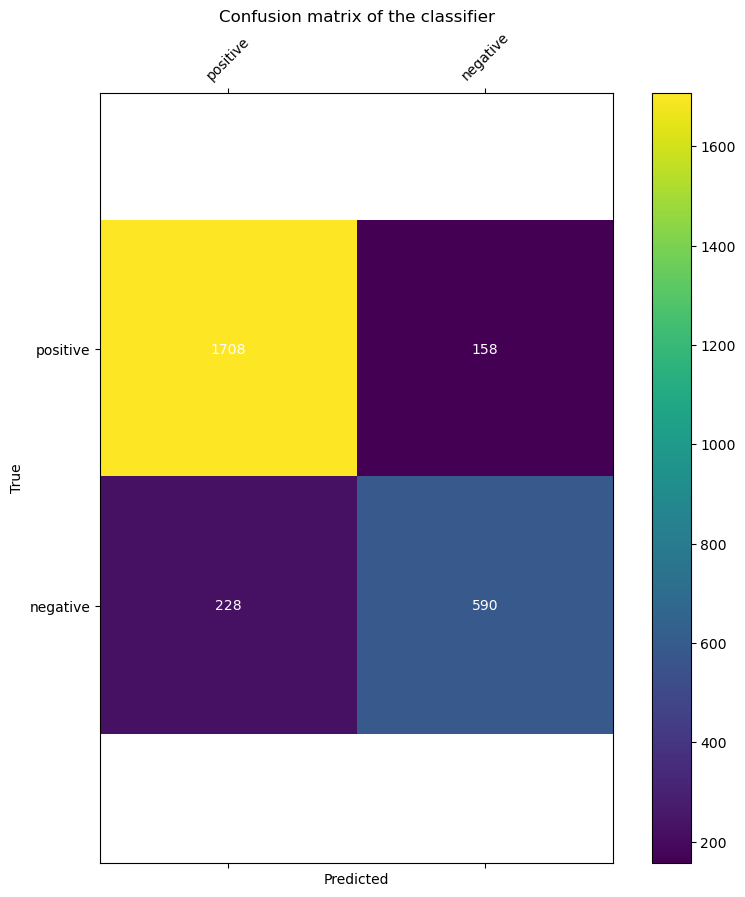

              precision    recall  f1-score   support

    positive       0.88      0.92      0.90      1866
    negative       0.79      0.72      0.75       818

    accuracy                           0.86      2684
   macro avg       0.84      0.82      0.83      2684
weighted avg       0.85      0.86      0.85      2684



In [31]:
kf = KFold(n_splits=10, shuffle=False)
features = [data[0] for data in train_data]
labels = [data[1] for data in train_data]
for train_index, test_index in kf.split(features):
    # Split the data into training and test sets for this fold
    X_train1, X_test1 = [features[i] for i in train_index], [features[i] for i in test_index]
    y_train1, y_test1 = [labels[i] for i in train_index], [labels[i] for i in test_index]
    #Train the classifier on the training data
    classifier = train_classifier(list(zip(X_train1, y_train1)))
    # Predict labels on the test data
    predicted_labels = predict_labels(X_test1, classifier)
    confusion_matrix_heatmap(y_test1,predicted_labels,['positive','negative'])
    #Breaking the loop as we need to plot confusion matrix only on first fold
    break
print(classification_report(y_test1,predicted_labels,labels = ['positive','negative']))

In [32]:
tru_label =  [label for text, label in test_data]
# print(predicted_labels)
for index, value in enumerate(tru_label):
    if predicted_labels[index] != value:
        print('FALSE prediction FOR {2} (prediction = {1}):\n {0}\n'.format(test_data[index][0], predicted_labels[index], value))
        print('*'*50)
        print()
        continue

FALSE prediction FOR positive (prediction = negative):
 {'i': 1, 'may': 1, 'be': 1, 'in': 1, 'the': 1, 'minority': 1, 'here': 1, ',': 1, 'but': 1, 'feel': 1, 'like': 1, 'george': 1, 'harrison': 1, 'pulled': 1, 'off': 1, '\\""': 1, 'full': 1, 'hobo\\""': 1, 'look': 1, 'better': 1, 'than': 1, 'john': 1, 'lennon': 1, '.': 1}

**************************************************

FALSE prediction FOR negative (prediction = positive):
 {'tony': 1, 'blair': 1, 'said': 1, "'": 1, 'god': 1, 'will': 1, 'judge': 1, 'me': 1, 'over': 1, 'iraq': 1, '.': 1, 'here': 1, 's': 1, 'another': 1, 'biblical': 1, 'truism': 1, ':': 1, 'you': 1, '[we]': 1, 'reap': 1, 'what': 1, 'sow': 1, ".'": 1, 'https': 1, '://t': 1, 'co/9e4vpntozd': 1}

**************************************************

FALSE prediction FOR positive (prediction = negative):
 {'i': 1, 'liked': 1, 'a': 1, '@youtube': 1, 'video': 1, 'http': 1, '://t': 1, '.': 1, 'co/pemh98r86t': 1, 'sen': 1, 'bernie': 1, 'sanders': 1, ':': 1, 'what': 1, 'would'

IndexError: list index out of range

# Questions 5: Optimising pre-processing and feature extraction (30 marks)

**Note:** it is advisable to implement question 5 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

In [ ]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3]) 